This notebook was developed by Tiffany Eulalio, modified by Minh Nguyen

# Labels

This notebook generates labels for the data up to 2020.

We will generate the following labels:
1. `admit_label`: level of care at time of admit
2. `recent_24hr_label`: most recent level of care prior to 24 hrs after admit
3. `max_24hr_label`: max level of care within 24 hours - already generated in initial cohort
3. `death_24hr_label`: indicates whether an individual died within 24 hours of admit
4. `recent_24hr_death`: 24 hour recent label with death label incorporated
5. `max_24hr_death`: 24 hour max label with death label incorporated
4. `acute_to_icu_label`: label switched from acute to ICU from admit to 24 hr time
5. `icu_to_acute_label`: label switched from ICU to acute from admit to 24 hr time


Labels 1 through 3 reflect the following:
- 1 = critical care
- 0 = not critical care 

Label 4:
- 1 = died within 24 hours
- 0 = did not die within 24 hours

Label 5 and 6:
- 1 if 24hr or death label is 1
- 0 otherwise

Labels 4 through 5 reflect:
- 1 = switched care level
- 0 = did not switch care level

# Import Packages and Data

- Import Python packages
- Set display settings for Pandas
- Initialize useful functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os.path
from os import path
import math

In [2]:
# setting display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# -- more display settings - use this to hide private data
forrepo = 0 # change this to 0 if you want to see hidden columns displayed

hidecols = []
if forrepo:
    hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns

## Useful Functions

In [3]:
# use this to describe the tables
def describe_df(df):
    print("df shape", df.shape)
    print("unique CSNs: ", df.pat_enc_csn_id_coded.nunique())
    print("unique patients: ", df.anon_id.nunique())

# Download Data

Only run this if the data is not downloaded locally yet

Download the Cohort table and ADT table.

## Cohort Table

## ADT Table

(We need to pull the `ADT` data for this new cohort. I already ran a SQL call directly on BQ to form the cohort.

Saved the file as `cohort_1_3_adt.csv`
 
Pull the `ADT` data for this new cohort. SQL code below:

# Load locally saved data

Load Cohort table and ADT table. Join them.

In [4]:
# folder with downloaded data locally
datadir = "../../DataTD/shc2021"
outdir = "../../OutputTD/shc2021"

## Cohort Table

In [34]:
# cohort = pd.read_csv("{}/1_3_cohort.csv".format(cohortdir))
cohort = pd.read_csv("{}/5_cohort3.csv".format(outdir))

# rename
cohort = cohort.rename({'label': 'label_max24'}, axis=1)

# cohort.drop('Unnamed: 0', axis=1, inplace=True)

print(cohort.shape) # (61176, 16)
cohort.drop(hidecols, axis=1, errors='ignore').head()

(61176, 10)


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp
0,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,75,79,18,127,37.00
1,JC1000116,131295313275,57868578,2020-09-29 22:45:00+00:00,0,77,81,18,120,36.80
2,JC1000296,131100574537,21370977,2015-07-03 04:51:00+00:00,0,63,120,20,98,37.05
3,JC1000441,131074233004,19747233,2015-02-23 06:51:00+00:00,0,66,60,18,127,36.00
4,JC1000441,131074471154,19773625,2015-02-26 23:07:00+00:00,0,65,57,18,115,37.00


### Note on admit time - no longer true

(The `admit_time` column contains the adjusted/earliest time between `admit_time_jittered` from the `ADT` table and the admission ordered time form the `order_proc` table. This is the time that we will use for the admission time.)

We are not going to use this admit time. Instead, we use the earliest admit time based on the `effective_time_jittered_utc` column in the `ADT` table. We'll grab the admit time from original init cohort0 for consistency, same as in `cohort_enc_code_age`

Looks like the admit time was already updated in this table. We can just use the original time.

## ADT Table

In [7]:
# load the ADT Table
# adt = pd.read_csv("{}/cohort_1_3_adt.csv".format(datadir))
adt = pd.read_csv("{}/cohort3_adt_2021.csv".format(datadir))

describe_df(adt)

adt.drop(hidecols, axis=1, errors='ignore').head()

df shape (1181264, 10)
unique CSNs:  61176
unique patients:  41015


,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,JC807097,131243864994,2018-02-19 07:59:00+00:00,35,Inpatient,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Census,Pulmonary Hypertension
1,JC2827561,131303950093,2021-01-15 18:48:00+00:00,7,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Gynecology
2,JC2112768,131319060216,2021-09-12 22:05:00+00:00,12,Inpatient,NaN,8.0,Critical Care,Patient Update,Pulmonary Hypertension
3,JC827598,131244657456,2018-01-22 07:59:00+00:00,20,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Census,Psych Oncology
4,JC2672958,131269829793,2019-05-25 21:47:00+00:00,20,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,General Medicine (T)


## Join Cohort and ADT

In [37]:
sub_cohort = cohort[['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 'label_max24']]
cohort_adt = sub_cohort.merge(adt, on=['anon_id', 'pat_enc_csn_id_coded'], how='left')
# cohort_adt = cohort_adt.rename({'label': 'label_max24'}, axis = 1)
cohort_adt.shape

(1181264, 13)

In [38]:
cohort_adt.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,2015-01-27 23:25:00+00:00,5,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency
1,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,2015-01-27 07:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency
2,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,2015-01-27 23:25:00+00:00,6,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency
3,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,2015-01-28 00:32:00+00:00,7,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency
4,JC1000116,131066472308,19328596,2015-01-28 00:46:00+00:00,0,2015-01-27 04:24:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency


In [39]:
# check that the join didn't mess anything up -- looks good, didn't lost any CSNs or anon_ids
print("cohort: ", cohort.shape, "adt: ", adt.shape, "demo_adt: ", cohort_adt.shape)

print("\nNumber of unique CSNs:")
print("cohort:", cohort.pat_enc_csn_id_coded.nunique(),
     "adt:", adt.pat_enc_csn_id_coded.nunique(),
     "cohort_adt:", cohort_adt.pat_enc_csn_id_coded.nunique())

print("\nNumber of unique anon_ids:")
print("cohort:", cohort.anon_id.nunique(),
     "adt:", adt.anon_id.nunique(),
     "cohort_adt:", cohort_adt.anon_id.nunique())

cohort:  (61176, 10) adt:  (1181264, 10) demo_adt:  (1181264, 13)

Number of unique CSNs:
cohort: 61176 adt: 61176 cohort_adt: 61176

Number of unique anon_ids:
cohort: 41015 adt: 41015 cohort_adt: 41015


In [40]:
# we don't need all of the columns, so keep only the necessary ones for this notebook
keep_cols = ['anon_id', 'pat_enc_csn_id_coded', 'label_max24', 
             'admit_time',
             'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
             'pat_lv_of_care', 'pat_service', 'event_type']

keep_cohort_adt = cohort_adt[keep_cols]

keep_cohort_adt.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type
0,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,5,Emergency Services,NaN,Emergency,Transfer Out
1,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 07:59:00+00:00,2,Emergency Services,NaN,Emergency,Census
2,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,6,Emergency Services,NaN,Emergency,Transfer In
3,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-28 00:32:00+00:00,7,Emergency Services,NaN,Emergency,Transfer Out
4,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 04:24:00+00:00,1,Emergency Services,NaN,Emergency,Admission


# Data Preprocessing and Quality Control

We need to change the times into datetime format so we can work with them to create the labels. Also, create a column that tells us how long it's been since admit time for each event in the `ADT` table.

## Convert times to datetime

In [41]:
# change the admit time to datetime
keep_cohort_adt.admit_time = pd.to_datetime(keep_cohort_adt.admit_time)

# change the effective time to datetime
keep_cohort_adt['effective_time_jittered_utc'] = pd.to_datetime(keep_cohort_adt.effective_time_jittered_utc)

keep_cohort_adt[['admit_time','effective_time_jittered_utc']].head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,admit_time,effective_time_jittered_utc
0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00
1,2015-01-28 00:46:00+00:00,2015-01-27 07:59:00+00:00
2,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00
3,2015-01-28 00:46:00+00:00,2015-01-28 00:32:00+00:00
4,2015-01-28 00:46:00+00:00,2015-01-27 04:24:00+00:00


In [42]:
# compute time since event - this step take a little while
keep_cohort_adt['effective_time_since_admit'] = keep_cohort_adt.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
key = "effective_time_since_admit"

# check out time since admit - some people have events prior to their admit_time label
print(keep_cohort_adt[key].describe(), "\n")

# look at all of the ADT events for these CSNs that occur prior to admission
prior_to_admit = keep_cohort_adt[keep_cohort_adt[key] < timedelta(hours=0)]

# number of ADT events that occur before admission
print("Number of ADT events that occur before admission: ", prior_to_admit.shape[0], "\n")

# this tells us where people were before admission
print("Pat class prior to admission: \n", prior_to_admit.pat_class.value_counts())

# how many csns have events prior to admit? 45,787
print(prior_to_admit.pat_enc_csn_id_coded.nunique())

prior_to_admit.drop(hidecols, axis=1, errors='ignore').head()

count                       1181264
mean      4 days 09:52:03.553176935
std      11 days 06:50:13.547089435
min               -8 days +01:34:00
25%                 0 days 01:16:00
50%                 0 days 22:48:00
75%                 4 days 06:22:00
max               371 days 23:54:00
Name: effective_time_since_admit, dtype: object 

Number of ADT events that occur before admission:  164302 

Pat class prior to admission: 
 Emergency Services    164298
Observation                2
Inpatient                  2
Name: pat_class, dtype: int64
61176


,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
0,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,5,Emergency Services,NaN,Emergency,Transfer Out,-1 days +22:39:00
1,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 07:59:00+00:00,2,Emergency Services,NaN,Emergency,Census,-1 days +07:13:00
2,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,6,Emergency Services,NaN,Emergency,Transfer In,-1 days +22:39:00
3,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-28 00:32:00+00:00,7,Emergency Services,NaN,Emergency,Transfer Out,-1 days +23:46:00
4,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-27 04:24:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +03:38:00


## Some patients have many CSNs in the cohort

Most patients only have one CSN in the `demo` table, but there are some with many CSNs. The max number of CSNs for one individual is 41. 

In [44]:
counts = keep_cohort_adt.groupby('anon_id')['pat_enc_csn_id_coded'].nunique().sort_values(ascending=False)

# distribution of CSNs per patient
print(counts.describe())

# number of patients with more than one CSN
print("\nPatients with multiple CSNs: ", sum(counts > 1))

counts.head(10)

count    41015.000000
mean         1.491552
std          1.360693
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         47.000000
Name: pat_enc_csn_id_coded, dtype: float64

Patients with multiple CSNs:  10120


anon_id
JC2456368    47
JC1241340    44
JC3252278    43
JC648147     36
JC1093600    35
JC1396494    34
JC582103     33
JC902851     33
JC518294     33
JC694106     28
Name: pat_enc_csn_id_coded, dtype: int64

# Admit Level of Care Label

We need to get the first admission event.

In [45]:
# try filtering for exact admit events
admit_events = keep_cohort_adt[keep_cohort_adt.admit_time == keep_cohort_adt.effective_time_jittered_utc] 

# filter for inpatient to get rid of multiple events occuring at admit time
admit_events = admit_events[admit_events.pat_class == "Inpatient"]

print("keep_cohort_adt")
describe_df(keep_cohort_adt)
print("\nadmit events")
describe_df(admit_events) # we don't lose any CSNs so that's good

keep_cohort_adt
df shape (1181264, 11)
unique CSNs:  61176
unique patients:  41015

admit events
df shape (61379, 11)
unique CSNs:  61176
unique patients:  41015


## Admit label issues

Some CSNs have no pat lv of care label at admit time.

In [46]:
# count the number of unique labels at admit time
care_counts = admit_events.groupby(['pat_enc_csn_id_coded']).pat_lv_of_care.nunique()
print("\n Number of admit events with distinct lv of care per CSN")
print(care_counts.describe())


 Number of admit events with distinct lv of care per CSN
count    61176.000000
mean         0.982869
std          0.129886
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: pat_lv_of_care, dtype: float64


In [47]:
# looks like some CSNs are missing an admit event label, 
admit_issues = care_counts[care_counts != 1].reset_index()

print("*** Number of CSNs missing admit lv of care:", admit_issues.shape[0])

admit_issues.sort_values('pat_lv_of_care').drop(hidecols, axis=1, errors='ignore')

*** Number of CSNs missing admit lv of care: 1050


,pat_enc_csn_id_coded,pat_lv_of_care
0,131063141711,0
691,131192565082,0
692,131192696901,0
693,131193084563,0
694,131193224666,0
...,...,...
356,131165834559,0
357,131165836287,0
358,131165836844,0
360,131165839761,0


### Patients missing lv of care 

There are some patients that are missing the `pat_lv_of_care` entry for the admit event. I looked through several manually and it looks like these individuals tend to be missing the `pat_lv_of_care` for all of their ADT events. This means we can't assign them any labels and so should be removed from the dataset.

In [48]:
# check on these missing admit CSNs
i = 2
missing_csns = admit_issues[admit_issues.pat_lv_of_care == 0]


missing_csns = missing_csns.pat_enc_csn_id_coded.values
print("csns missing admit pat_lv_of_care: ", len(missing_csns))

missing_csn = missing_csns[i]
check = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc']).drop(hidecols, axis=1, errors='ignore')

csns missing admit pat_lv_of_care:  1049


,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
561036,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 05:03:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +18:13:00
561033,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 07:59:00+00:00,2,Emergency Services,NaN,Emergency,Census,-1 days +21:09:00
561034,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 10:23:00+00:00,3,Emergency Services,NaN,Emergency,Transfer Out,-1 days +23:33:00
561037,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 10:23:00+00:00,4,Emergency Services,NaN,Emergency,Transfer In,-1 days +23:33:00
561035,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 10:50:00+00:00,5,Emergency Services,NaN,Emergency,Transfer Out,0 days 00:00:00
561038,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 10:50:00+00:00,6,Inpatient,NaN,General Medicine (University),Transfer In,0 days 00:00:00
561039,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 11:42:00+00:00,8,Inpatient,NaN,General Medicine (University),Transfer In,0 days 00:52:00
561040,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 11:42:00+00:00,7,Inpatient,NaN,General Medicine (University),Transfer Out,0 days 00:52:00
561031,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 12:48:00+00:00,9,OP Surgery/Procedure,NaN,Gynecology,Patient Update,0 days 01:58:00
561032,JC2225696,131063679760,0,2015-01-10 10:50:00+00:00,2015-01-10 13:32:00+00:00,10,OP Surgery/Procedure,NaN,Gynecology,Discharge,0 days 02:42:00


In [49]:
# find patients with NaN only for lv of care
missing_adt = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded.isin(missing_csns)]

# find those missing admit label, but have lv of care somewhere in adt table
not_all_nan = missing_adt[~missing_adt.pat_lv_of_care.isnull()]

# get csns from these events
not_all_nan_csns = not_all_nan.pat_enc_csn_id_coded.unique()


# find those that have no pav lv of care
fully_missing_csns = [x for x in missing_csns if not x in not_all_nan_csns]

# grab adt table for these
missing_csns_adt = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded.isin(fully_missing_csns)]
# missing_csns_adt.to_csv("../2019_data/cohort_2019_missing_pat_lv_of_care.csv")

print("Number of CSNS missing pat lv of care across ALL events:", len(fully_missing_csns)) # through the entire stays #202

Number of CSNS missing pat lv of care across ALL events: 202


#### Remove CSNs with missing level of care across the entire ADT table.

In [50]:
# filter down the cohort adt table
filtered_cohort_adt = keep_cohort_adt[~keep_cohort_adt.pat_enc_csn_id_coded.isin(fully_missing_csns)]

print("keep_cohort_adt")
describe_df(keep_cohort_adt)
print("\nfiltered_cohort_adt")
describe_df(filtered_cohort_adt) # removed 201 patients


# filter down the cohort table
filtered_cohort = cohort[~cohort.pat_enc_csn_id_coded.isin(fully_missing_csns)]
print("\n\ncohort_adt")
describe_df(cohort_adt)
print("\nfiltered_cohort")
describe_df(filtered_cohort) # removed 202 patients

keep_cohort_adt
df shape (1181264, 11)
unique CSNs:  61176
unique patients:  41015

filtered_cohort_adt
df shape (1178369, 11)
unique CSNs:  60974
unique patients:  40892


cohort_adt
df shape (1181264, 13)
unique CSNs:  61176
unique patients:  41015

filtered_cohort
df shape (60974, 10)
unique CSNs:  60974
unique patients:  40892


In [158]:
filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == 131317607355].sort_values('seq_num_in_enc')

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
234127,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 04:14:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +21:14:00
234130,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 04:33:00+00:00,2,Emergency Services,NaN,Emergency Medicine,Patient Update,-1 days +21:33:00
234131,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 06:59:00+00:00,3,Emergency Services,NaN,Emergency Medicine,Census,-1 days +23:59:00
234128,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,4,Emergency Services,NaN,Emergency Medicine,Transfer Out,0 days 00:00:00
234129,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,5,Emergency Services,NaN,Emergency Medicine,Transfer In,0 days 00:00:00
234122,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,6,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Patient Update,0 days 00:00:00
234124,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,7,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Transfer Out,0 days 00:00:00
234125,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,8,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Transfer In,0 days 00:00:00
234126,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,9,Inpatient,IICU/Intermediate Care (Assessment or interven...,Medicine,Patient Update,0 days 00:00:00
234123,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,10,Inpatient,IICU/Intermediate Care (Assessment or interven...,Medicine,Census,0 days 00:00:00


## Create labels for patients that have admit events with lv of care

In [159]:
# keep only patients with one lv of care label at admit time
counts = care_counts.reset_index()
keep_csns = counts[counts.pat_lv_of_care >= 1].pat_enc_csn_id_coded.values

counts.sort_values('pat_lv_of_care')

keep_admits = admit_events[admit_events.pat_enc_csn_id_coded.isin(keep_csns)]

print("filtered_cohort_adt")
describe_df(filtered_cohort_adt)
print("\nkeep admits")
describe_df(keep_admits) # there are multiple inpatient admit events, but they have the same label so it's okay

print("\nkeep admits + removed csns =", 
      keep_admits.pat_enc_csn_id_coded.nunique() + len(missing_csns)) # we're only missing the ones with no labels

filtered_cohort_adt
df shape (1178369, 11)
unique CSNs:  60974
unique patients:  40892

keep admits
df shape (60322, 11)
unique CSNs:  60127
unique patients:  40420

keep admits + removed csns = 60453


In [160]:
keep_admits.head()

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
12,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-28 00:46:00+00:00,10,Inpatient,Acute Care (Assessment or intervention q4-8),General Medicine (University),Transfer In,0 days
35,JC1000116,131295313275,0,2020-09-29 22:45:00+00:00,2020-09-29 22:45:00+00:00,3,Inpatient,Acute Care (Assessment or intervention q4-8),Neurology/Stroke Svc,Patient Update,0 days
51,JC1000296,131100574537,0,2015-07-03 04:51:00+00:00,2015-07-03 04:51:00+00:00,8,Inpatient,Acute Care (Assessment or intervention q4-8),Bone Marrow Transplant,Transfer In,0 days
68,JC1000441,131074233004,0,2015-02-23 06:51:00+00:00,2015-02-23 06:51:00+00:00,11,Inpatient,Acute Care (Assessment or intervention q4-8),General Surgery,Transfer In,0 days
103,JC1000527,131084989828,0,2015-05-26 23:19:00+00:00,2015-05-26 23:19:00+00:00,5,Inpatient,Intermediate Care - With Cardiac Monitor,Cardiology,Transfer In,0 days


In [161]:
# keep only the first admit event for each csn
# all admit events have same label so it's okay to keep - checked these already
unique_admits = keep_admits.sort_values(['pat_enc_csn_id_coded','seq_num_in_enc']).groupby("pat_enc_csn_id_coded").first().reset_index()

admit_labels = unique_admits[['pat_enc_csn_id_coded', 'pat_lv_of_care']]
print(admit_labels.pat_lv_of_care.value_counts()) # these NeoNatal ICU and Newborn Nursery might be weird to keep ***

admit_labels['admit_label'] = (admit_labels.pat_lv_of_care == "Critical Care").astype(int)

print("\nCount for admit labels:")
print(admit_labels.admit_label.value_counts())

admit_labels.drop(hidecols, axis=1, errors='ignore')

Acute Care (Assessment or intervention q4-8)                43718
Critical Care                                                6539
Intermediate Care - With Cardiac Monitor                     6167
IICU/Intermediate Care (Assessment or intervention q2-4)     3547
Intermediate Care - No Cardiac Monitor                        151
Newborn Nursery - VC Only                                       3
Neonatal ICU - VC Only                                          2
Name: pat_lv_of_care, dtype: int64

Count for admit labels:
0    53588
1     6539
Name: admit_label, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pat_enc_csn_id_coded,pat_lv_of_care,admit_label
0,131062572931,Intermediate Care - With Cardiac Monitor,0
1,131062745090,Acute Care (Assessment or intervention q4-8),0
2,131062927111,Critical Care,1
3,131063006922,Intermediate Care - With Cardiac Monitor,0
4,131063022232,Critical Care,1
...,...,...,...
60122,131320753559,Acute Care (Assessment or intervention q4-8),0
60123,131320788661,Acute Care (Assessment or intervention q4-8),0
60124,131320816550,Acute Care (Assessment or intervention q4-8),0
60125,131320867371,Acute Care (Assessment or intervention q4-8),0


In [162]:
keep_admits[keep_admits.pat_enc_csn_id_coded == 131317607355]

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
234122,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,6,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Patient Update,0 days
234123,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,10,Inpatient,IICU/Intermediate Care (Assessment or interven...,Medicine,Census,0 days
234124,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,7,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Transfer Out,0 days
234125,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,8,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Transfer In,0 days
234126,JC1640877,131317607355,0,2021-09-30 07:00:00+00:00,2021-09-30 07:00:00+00:00,9,Inpatient,IICU/Intermediate Care (Assessment or interven...,Medicine,Patient Update,0 days


### Weird admit labels

Decide whether to keep these (NeoNatal ICU and Newborn Nursery) labels or not. - probably keep them

Join labels to cohort

In [163]:
filtered_cohort_labels = filtered_cohort[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'label_max24']].merge(
    admit_labels[['pat_enc_csn_id_coded', 'admit_label']], how='left')

# some are mising an admit label because they were NaN at admit time
sum(filtered_cohort_labels.admit_label.isnull())

filtered_cohort_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0.0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0.0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0.0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0.0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,NaN
...,...,...,...,...,...
60969,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0.0
60970,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0.0
60971,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0.0
60972,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0.0


In [164]:
filtered_cohort_labels[filtered_cohort_labels.pat_enc_csn_id_coded == 131317607355]

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label
12209,JC1640877,131317607355,2021-09-30 07:00:00+00:00,0,0.0


# Choose hour here ---

Choose the hour for the label to make

In [572]:
X = 9

# Most Recent Care Labels

Now we'll get the labels for the most recent event prior to X hours, for X=12 and 24.

In [573]:
# get the adt table for events that happen between admit and X hours only
def get_adtX(X):
    # take only events that occur after admit but before the X hours mark
    adt_X = filtered_cohort_adt[(filtered_cohort_adt.effective_time_since_admit >= timedelta(hours=0))
                                 &
                                 (filtered_cohort_adt.effective_time_since_admit <= timedelta(hours=X))
                                &
                                (~filtered_cohort_adt.pat_lv_of_care.isnull())
                                ]

    # check out distribution of times
    print(adt_X.effective_time_since_admit.describe(), "\n")
    
    print("filtered_cohort_adt")
    describe_df(filtered_cohort_adt)
    print("\nadt_X")
    # check if we lost anyone - we're missing some
    describe_df(adt_X)


    print("\nmissing number of csns:")
    filtered_cohort_csns = filtered_cohort_adt.pat_enc_csn_id_coded.unique()
    adt_X_csns = adt_X.pat_enc_csn_id_coded.unique()
    print(len(filtered_cohort_csns) - len(adt_X_csns))
    
    # get these missing csns to manual check
    missing_csns = [x for x in filtered_cohort_csns if x not in adt_X_csns]
    
    return (adt_X, missing_csns)

In [574]:
print("Creating label for hour", X)
adt_X, missing_csns = get_adtX(X) # missing csn = no events within 0-3 hours

Creating label for hour 9
count                       322666
mean     0 days 02:22:54.639038510
std      0 days 02:14:46.716696081
min                0 days 00:00:00
25%                0 days 00:42:00
50%                0 days 01:46:00
75%                0 days 03:30:00
max                0 days 09:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (1178369, 11)
unique CSNs:  60974
unique patients:  40892

adt_X
df shape (322666, 11)
unique CSNs:  60817
unique patients:  40808

missing number of csns:
157


# Create max level of care label for this hour

In [575]:
adt_X.head()

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
12,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-28 00:46:00+00:00,10,Inpatient,Acute Care (Assessment or intervention q4-8),General Medicine (University),Transfer In,0 days 00:00:00
16,JC1000116,131066472308,0,2015-01-28 00:46:00+00:00,2015-01-28 07:59:00+00:00,11,Inpatient,Acute Care (Assessment or intervention q4-8),General Medicine (University),Census,0 days 07:13:00
35,JC1000116,131295313275,0,2020-09-29 22:45:00+00:00,2020-09-29 22:45:00+00:00,3,Inpatient,Acute Care (Assessment or intervention q4-8),Neurology/Stroke Svc,Patient Update,0 days 00:00:00
36,JC1000116,131295313275,0,2020-09-29 22:45:00+00:00,2020-09-30 06:59:00+00:00,8,Inpatient,Acute Care (Assessment or intervention q4-8),Neurology/Stroke Svc,Census,0 days 08:14:00
38,JC1000116,131295313275,0,2020-09-29 22:45:00+00:00,2020-09-30 00:40:00+00:00,5,Inpatient,Acute Care (Assessment or intervention q4-8),Neurology/Stroke Svc,Transfer In,0 days 01:55:00


In [576]:
adt_X.pat_lv_of_care.unique()

array(['Acute Care (Assessment or intervention q4-8)',
       'Intermediate Care - With Cardiac Monitor', 'Critical Care',
       'IICU/Intermediate Care (Assessment or intervention q2-4)',
       'Intermediate Care - No Cardiac Monitor', 'Neonatal ICU - VC Only',
       'Newborn Nursery - VC Only'], dtype=object)

In [577]:
# check the max level of care within X hours
# 1 if patients went to critical care
# 0 otherwise
def get_max_label(adt_X):
    # filter to just the critical events
    critical_adt_X = adt_X[adt_X.pat_lv_of_care.isin(['Critical Care'])]
    
    # check which csns have had this event
    max_label_X = adt_X[['anon_id', 'pat_enc_csn_id_coded']].drop_duplicates()
    max_label_name = "label_max{}".format(X)
    max_label_X[max_label_name] = max_label_X.pat_enc_csn_id_coded.isin(critical_adt_X.pat_enc_csn_id_coded)*1
    return(max_label_X)

In [578]:
max_labels = get_max_label(adt_X)
max_labels

,anon_id,pat_enc_csn_id_coded,label_max9
12,JC1000116,131066472308,0
35,JC1000116,131295313275,0
51,JC1000296,131100574537,0
68,JC1000441,131074233004,0
81,JC1000441,131074471154,0
...,...,...,...
1181156,JC999695,131213219561,0
1181178,JC999744,131203232261,0
1181198,JC999744,131208988464,0
1181232,JC999925,131107270857,0


# Missing X hour labels

There are individuals missing 24 hr labels. I checked the first three and they seem to be those with NaN values for `pat_lv_of_care` for all events that occur within 24 hours.

In [579]:
i = 0
missing_csn = missing_csns[i]
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check.sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
4709,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-11 15:14:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +22:24:00
4706,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-11 15:38:00+00:00,3,Emergency Services,NaN,Emergency,Transfer In,-1 days +22:48:00
4708,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-11 15:38:00+00:00,2,Emergency Services,NaN,Emergency,Transfer Out,-1 days +22:48:00
4707,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-11 16:50:00+00:00,4,Emergency Services,NaN,Emergency,Transfer Out,0 days 00:00:00
4720,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-11 16:50:00+00:00,5,Inpatient,NaN,Cardiology,Transfer In,0 days 00:00:00
4723,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-12 06:59:00+00:00,6,Inpatient,NaN,Cardiology,Census,0 days 14:09:00
4714,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-13 06:59:00+00:00,7,Inpatient,NaN,Cardiology,Census,1 days 14:09:00
4713,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-13 23:31:00+00:00,8,Inpatient,NaN,Cardiology,Patient Update,2 days 06:41:00
4718,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-14 06:59:00+00:00,9,Inpatient,NaN,Cardiology,Census,2 days 14:09:00
4721,JC1019078,131094146837,0,2015-07-11 16:50:00+00:00,2015-07-15 06:59:00+00:00,10,Inpatient,NaN,Cardiology,Census,3 days 14:09:00


In [580]:
# gets the most recent event before X hours
def get_recent_events(adt_X):
    # sort by the effective time of events
    adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)
    # 'seq_num_in_bed_min' - used to be sorted by this also, but we don't have this col anymore

    describe_df(adt_X)

    # group by CSN and get first event 
    recent_events = adt_X.groupby('pat_enc_csn_id_coded').last().reset_index()

    print(recent_events.effective_time_since_admit.describe())

    return recent_events

recent_events = get_recent_events(adt_X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


df shape (322666, 11)
unique CSNs:  60817
unique patients:  40808
count                        60817
mean     0 days 04:13:48.425604682
std      0 days 02:34:20.129197145
min                0 days 00:00:00
25%                0 days 02:01:00
50%                0 days 03:59:00
75%                0 days 06:26:00
max                0 days 09:00:00
Name: effective_time_since_admit, dtype: object


# Some patients' most recent event is very early

Minimum is 1 minute after admit. Check this guy out.

In [581]:
recent_events.sort_values(by=['effective_time_since_admit']).head().drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,anon_id,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
3882,131091532856,JC686657,0,2015-05-24 09:12:00+00:00,2015-05-24 09:12:00+00:00,6,Inpatient,Acute Care (Assessment or intervention q4-8),General Medicine (University),Transfer In,0 days
3624,131090498007,JC1468453,0,2015-06-24 07:12:00+00:00,2015-06-24 07:12:00+00:00,6,Inpatient,Acute Care (Assessment or intervention q4-8),General Medicine (University),Transfer In,0 days
1952,131080142161,JC1539132,0,2015-02-24 14:22:00+00:00,2015-02-24 14:22:00+00:00,5,Inpatient,Intermediate Care - With Cardiac Monitor,Cardiology,Transfer In,0 days
1953,131080142234,JC650517,0,2015-04-09 19:52:00+00:00,2015-04-09 19:52:00+00:00,5,Inpatient,Acute Care (Assessment or intervention q4-8),Orthopaedic Surgery,Transfer In,0 days
1954,131080150048,JC1753695,0,2015-03-29 20:34:00+00:00,2015-03-29 20:34:00+00:00,3,Inpatient,Intermediate Care - With Cardiac Monitor,General Medicine (University),Transfer In,0 days


In [582]:
# this checks out, so at least nothing wrong with code
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == 131263388404]
check.sort_values('effective_time_since_admit').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
688142,JC2773253,131263388404,0,2019-01-20 04:13:00+00:00,2019-01-19 23:09:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +18:56:00
688139,JC2773253,131263388404,0,2019-01-20 04:13:00+00:00,2019-01-20 04:13:00+00:00,2,Inpatient,Acute Care (Assessment or intervention q4-8),Oncology,Patient Update,0 days 00:00:00
688141,JC2773253,131263388404,0,2019-01-20 04:13:00+00:00,2019-01-20 04:14:00+00:00,3,Observation,NaN,Emergency,Patient Update,0 days 00:01:00
688140,JC2773253,131263388404,0,2019-01-20 04:13:00+00:00,2019-01-20 06:44:00+00:00,4,Observation,NaN,Emergency,Discharge,0 days 02:31:00


In [583]:
# we have one row for each event now - each row is the last entry for each event prior to 24 hr mark
print(recent_events.pat_enc_csn_id_coded.nunique()) #60648
print(recent_events.shape)

describe_df(recent_events)

recent_events.effective_time_since_admit.describe()

60817
(60817, 11)
df shape (60817, 11)
unique CSNs:  60817
unique patients:  40808


count                        60817
mean     0 days 04:13:48.425604682
std      0 days 02:34:20.129197145
min                0 days 00:00:00
25%                0 days 02:01:00
50%                0 days 03:59:00
75%                0 days 06:26:00
max                0 days 09:00:00
Name: effective_time_since_admit, dtype: object

## Continue with labels again

In [584]:
# look at the level of care assignments across all individuals
print(recent_events.pat_lv_of_care.value_counts())

sum(recent_events.pat_lv_of_care.isnull()) # these are NaN lv of care prior to 24 hr

Acute Care (Assessment or intervention q4-8)                42887
Critical Care                                                7030
Intermediate Care - With Cardiac Monitor                     6359
IICU/Intermediate Care (Assessment or intervention q2-4)     4392
Intermediate Care - No Cardiac Monitor                        149
Name: pat_lv_of_care, dtype: int64


0

In [585]:
label_name = "label_{}hr_recent".format(X)
recent_events[label_name] = (recent_events.pat_lv_of_care == 'Critical Care').astype(int)
recent_events.head().drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,anon_id,label_max24,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit,label_9hr_recent
0,131062572931,JC1170548,0,2015-01-02 03:48:00+00:00,2015-01-02 07:59:00+00:00,6,Inpatient,Intermediate Care - With Cardiac Monitor,General Medicine (University),Census,0 days 04:11:00,0
1,131062745090,JC913990,0,2015-01-02 05:53:00+00:00,2015-01-02 07:59:00+00:00,10,Inpatient,Acute Care (Assessment or intervention q4-8),Orthopaedic Surgery,Census,0 days 02:06:00,0
2,131062927111,JC529112,1,2015-01-05 03:20:00+00:00,2015-01-05 07:59:00+00:00,8,Inpatient,Critical Care,Critical Care,Census,0 days 04:39:00,1
3,131063006922,JC1702404,0,2015-01-06 14:47:00+00:00,2015-01-06 15:30:00+00:00,8,Inpatient,Intermediate Care - With Cardiac Monitor,General Medicine (University),Patient Update,0 days 00:43:00,0
4,131063022232,JC523028,1,2015-01-03 21:24:00+00:00,2015-01-03 21:24:00+00:00,5,Inpatient,Critical Care,Critical Care,Transfer In,0 days 00:00:00,1


In [586]:
filtered_cohort_labels

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0.0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0.0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0.0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0.0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,NaN
...,...,...,...,...,...
60969,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0.0
60970,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0.0
60971,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0.0
60972,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0.0


In [587]:
# grab relevant columns
labels = recent_events[['pat_enc_csn_id_coded', label_name]]

# join to demo table
filtered_cohort_labels2 = filtered_cohort_labels.merge(labels, how='left', on='pat_enc_csn_id_coded')
filtered_cohort_labels2[label_name] = filtered_cohort_labels2[label_name]

# join the max label
filtered_cohort_labels2 = filtered_cohort_labels2.merge(max_labels, how='left')

filtered_cohort_labels2.head().drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0.0,0.0,0.0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0.0,0.0,0.0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0.0,0.0,0.0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0.0,0.0,0.0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,NaN,0.0,0.0


In [588]:
# convert all labels to integers

recent_label_name = "label_{}hr_recent".format(X)
max_label_name = "label_max{}".format(X)

filtered_cohort_labels2.admit_label = filtered_cohort_labels2.admit_label.astype("Int64")
filtered_cohort_labels2[recent_label_name] = filtered_cohort_labels2[recent_label_name].astype("Int64")
filtered_cohort_labels2[max_label_name] = filtered_cohort_labels2[max_label_name].astype("Int64")


filtered_cohort_labels2.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0
...,...,...,...,...,...,...,...
60969,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,0
60970,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,0
60971,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,0
60972,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,0


In [589]:
# check the missing label count for all labels
print(sum(filtered_cohort_labels2.admit_label.isnull()))

print(sum(filtered_cohort_labels2[max_label_name].isnull()))

847
157


In [590]:
# check label distribution
print(filtered_cohort_labels2['admit_label'].value_counts(), "\n")
print(filtered_cohort_labels2[label_name].value_counts(), "\n")

0    53588
1     6539
Name: admit_label, dtype: Int64 

0    53787
1     7030
Name: label_9hr_recent, dtype: Int64 



In [591]:
describe_df(filtered_cohort_labels2)

df shape (60974, 7)
unique CSNs:  60974
unique patients:  40892


In [592]:
filtered_cohort_labels2.head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0


## Deal with individuals with NaN admit lv of care

Some CSNs do not have admit labels, but they do have 24 hour labels. We will 
1. give these people a label based on their earliest level of care and their X hour label. 
2. We'll include a flag to indicate that these people didn't have admit labels. 
3. We'll also include the time of their earliest label.

In [593]:
# get flag to indicate whether individuals had an admit label
# switch_labels = filtered_cohort_labels2
filtered_cohort_labels2['has_admit_label'] = (~filtered_cohort_labels2.admit_label.isnull()).astype(int)
print(filtered_cohort_labels2.has_admit_label.value_counts())

filtered_cohort_labels2.head()

# subset to those that do not have admit label
no_admit = filtered_cohort_labels2[filtered_cohort_labels2.has_admit_label == 0]
no_admit.head()
no_admit_csns = no_admit.pat_enc_csn_id_coded.values

print("\nnew cohort:")
print(describe_df(filtered_cohort_labels2))
print("\nno admit")
print(describe_df(no_admit)) # 787 CSNs with no admit time

1    60127
0      847
Name: has_admit_label, dtype: int64

new cohort:
df shape (60974, 8)
unique CSNs:  60974
unique patients:  40892
None

no admit
df shape (847, 8)
unique CSNs:  847
unique patients:  832
None


# Missing all labels

There are some people who are missing labels for admit time, and 24 hr. We can't really do anything with these right now. We'll identify these individuals and remove them from the cohort.

We can also look at the distribution of their first labels.

1    157
Name: admit_label, dtype: int64
count    157.000000
mean      37.674628
std       43.318529
min        9.016667
25%       15.616667
50%       25.050000
75%       41.566667
max      330.900000
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

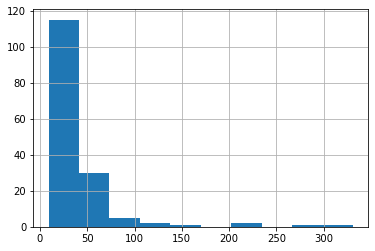

In [594]:
# these are the label names that we want to use
# recent_label_name = "label_{}hr_recent".format(X)
# max_label_name = "label_max{}".format(X)

# find csns with no labels across the board
missing_labels = filtered_cohort_labels2[['admit_label', 
                        recent_label_name]].isnull().astype(int)
missing_labels['pat_enc_csn_id_coded'] = filtered_cohort_labels2['pat_enc_csn_id_coded']

no_admit = missing_labels[missing_labels.admit_label == 1] 
no_labels = no_admit[no_admit[recent_label_name] == 1]

print(no_labels['admit_label'].value_counts()) # 82 people have no labels before 24 hrs

# manuall check some of them - looks good
# new_cohort[new_cohort.pat_enc_csn_id_coded == no_labels.pat_enc_csn_id_coded.values[50]]

no_labels_csns = no_labels.pat_enc_csn_id_coded.values # will probably remove these from cohort

# pull the adt for these CSNs with no admit times
no_labels_adt = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded.isin(no_labels_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = no_labels_adt[~no_labels_adt.pat_lv_of_care.isnull()]
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'effective_time_jittered_utc'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())
hour_since_admit.hist()

# Continue without these individuals


690
690
count    690.000000
mean       1.913623
std        2.044717
min        0.016667
25%        0.133333
50%        1.383333
75%        2.962500
max        8.916667
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

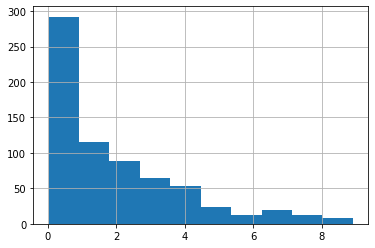

In [595]:
# keep the no_admit cohort but not the no_label cohort
has_some_label = filtered_cohort_labels2[~filtered_cohort_labels2.pat_enc_csn_id_coded.isin(no_labels_csns)] # 708 are left
admit_cohort = has_some_label[has_some_label.pat_enc_csn_id_coded.isin(no_admit_csns)]

## find the earliest level of care 
admit_cohort_csns = admit_cohort.pat_enc_csn_id_coded.values

# pull the adt for these CSNs with no admit times
admit_cohort_adt = filtered_cohort_adt[
    filtered_cohort_adt.pat_enc_csn_id_coded.isin(admit_cohort_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = admit_cohort_adt[~admit_cohort_adt.pat_lv_of_care.isnull()]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique()) # 522 has no admit label but some label within the first X hours
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique()) # 521: 1 has a label before admit time
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'effective_time_jittered_utc',
                              'seq_num_in_enc'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first().reset_index()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())  
hour_since_admit.hist()

In [596]:
# we now have the first event for each CSN
print(first_label.pat_enc_csn_id_coded.nunique()) # 708 - we have everyone, except that one that dropped off
first_label_short = first_label[['pat_enc_csn_id_coded', 'pat_lv_of_care', 'effective_time_since_admit']]

# check out lv of care here
print(first_label_short.pat_lv_of_care.value_counts())

# make sure no null values
print(sum(first_label_short.pat_lv_of_care.isnull())) # 0 = good

# create label
first_label_short['first_label'] = (first_label_short.pat_lv_of_care == 'Critical Care').astype(int)

print(first_label_short.first_label.value_counts()) # makes sense

# rename the time since admit column
first_label_short.rename({'effective_time_since_admit': 'first_label_time_since_admit'}, 
                         axis='columns', inplace=True)

first_label_short.drop(hidecols, axis=1, errors='ignore')

690
Acute Care (Assessment or intervention q4-8)                432
Intermediate Care - With Cardiac Monitor                    126
Critical Care                                               101
IICU/Intermediate Care (Assessment or intervention q2-4)     30
Intermediate Care - No Cardiac Monitor                        1
Name: pat_lv_of_care, dtype: int64
0
0    589
1    101
Name: first_label, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pat_enc_csn_id_coded,pat_lv_of_care,first_label_time_since_admit,first_label
0,131063452483,Critical Care,0 days 02:08:00,1
1,131065135648,Intermediate Care - With Cardiac Monitor,0 days 01:14:00,0
2,131065392332,Critical Care,0 days 02:30:00,1
3,131065794016,Acute Care (Assessment or intervention q4-8),0 days 04:23:00,0
4,131066453320,Intermediate Care - With Cardiac Monitor,0 days 08:10:00,0
...,...,...,...,...
685,131314408103,Critical Care,0 days 00:12:00,1
686,131314973086,Acute Care (Assessment or intervention q4-8),0 days 02:42:00,0
687,131316433454,Acute Care (Assessment or intervention q4-8),0 days 02:13:00,0
688,131317031186,Critical Care,0 days 00:47:00,1


# Checking into the first label time distribution

In [597]:
first_label_short['first_label_minutes_since_admit'] = first_label_short.first_label_time_since_admit / pd.Timedelta('1 minute')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [598]:
ordered_first_labels = first_label_short.sort_values('first_label_minutes_since_admit', ascending=False)
ordered_first_labels.drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,pat_lv_of_care,first_label_time_since_admit,first_label,first_label_minutes_since_admit
173,131167406143,Intermediate Care - With Cardiac Monitor,0 days 08:55:00,0,535.0
369,131195545988,Acute Care (Assessment or intervention q4-8),0 days 08:50:00,0,530.0
22,131081841150,Acute Care (Assessment or intervention q4-8),0 days 08:29:00,0,509.0
158,131166248824,Intermediate Care - With Cardiac Monitor,0 days 08:17:00,0,497.0
4,131066453320,Intermediate Care - With Cardiac Monitor,0 days 08:10:00,0,490.0
...,...,...,...,...,...
570,131264605374,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0
572,131265527017,Critical Care,0 days 00:01:00,1,1.0
573,131265896621,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0
574,131265962386,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0


In [599]:
i=1
csn = ordered_first_labels.pat_enc_csn_id_coded.values[i]
keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded == csn][['pat_enc_csn_id_coded', 'admit_time',
                                                                 'pat_class', 'pat_lv_of_care',
                                                                 'effective_time_jittered_utc', 
                                                                 'effective_time_since_admit']].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,admit_time,pat_class,pat_lv_of_care,effective_time_jittered_utc,effective_time_since_admit
458638,131195545988,2016-07-25 21:23:00+00:00,Emergency Services,NaN,2016-07-25 17:41:00+00:00,-1 days +20:18:00
458639,131195545988,2016-07-25 21:23:00+00:00,Emergency Services,NaN,2016-07-25 21:01:00+00:00,-1 days +23:38:00
458640,131195545988,2016-07-25 21:23:00+00:00,Emergency Services,NaN,2016-07-25 21:01:00+00:00,-1 days +23:38:00
458636,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-25 21:23:00+00:00,0 days 00:00:00
458641,131195545988,2016-07-25 21:23:00+00:00,Emergency Services,NaN,2016-07-25 21:23:00+00:00,0 days 00:00:00
458634,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-25 21:49:00+00:00,0 days 00:26:00
458635,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-25 21:49:00+00:00,0 days 00:26:00
458637,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-26 00:01:00+00:00,0 days 02:38:00
458647,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-26 00:01:00+00:00,0 days 02:38:00
458659,131195545988,2016-07-25 21:23:00+00:00,Inpatient,NaN,2016-07-26 06:13:00+00:00,0 days 08:50:00


array([[<AxesSubplot:title={'center':'first_label_minutes_since_admit'}>]],
      dtype=object)

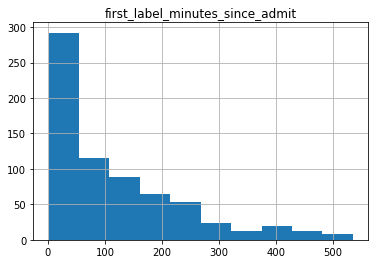

In [600]:
first_label_short.hist('first_label_minutes_since_admit')

In [601]:
# join the first labels to the new cohort
new_cohort_labels = filtered_cohort_labels2.merge(first_label_short[['pat_enc_csn_id_coded', 'first_label', 
                                                                     'first_label_minutes_since_admit']],
                how='left')

In [602]:
new_cohort_labels_full = new_cohort_labels[~new_cohort_labels.pat_enc_csn_id_coded.isin(no_labels_csns)]

print("new cohort labels")
describe_df(new_cohort_labels)
print("\nnew cohort labels full")
describe_df(new_cohort_labels_full) # we lose those 82 csns that had no labels across the board

new cohort labels
df shape (60974, 10)
unique CSNs:  60974
unique patients:  40892

new cohort labels full
df shape (60817, 10)
unique CSNs:  60817
unique patients:  40808


# Death Labels

Checking on the patients that died in our cohort. Specifically looking for any that died within 24 hours of being admitted.

We will change their 24 hour label to 1 if it is not already.

## Format the data

Reading in files that were pulled and saved from BQ.

Query death dates from BQ using the SQL code below.

Saved the results as `cohort_1_3_demo_deaths18.csv` and `cohort_1_3_demo_deaths19.csv`.

Pull the demographics table for our cohort with the death date included. If the death date is NaN, then the individual is considered alive.

The 2018 data was pulled from the initial database, and then 2019 data was pulled from a later release.

We need both of these because if a patient dies prior to 2018, their death date is not correctly listed in the 2019 data.

SQL to pull the 2019 death dates from demographics table:

In [603]:
# read in the file
deaths = pd.read_csv("{}/cohort3_demo_deaths_2021.csv".format(datadir))
# deaths21 = pd.read_csv("{}/cohort_6_7_demo_deaths.csv".format(datadir))

deaths.shape

(41015, 2)

In [604]:
# how many anon_ids do we have in the deaths table? 30,451
cohort_deaths = deaths[deaths.anon_id.isin(new_cohort_labels_full.anon_id)]

# add the 2021 csns
# cohort_deaths = pd.concat([cohort_deaths, deaths21], axis=0)
# print(cohort_deaths.anon_id.nunique())

# number of unique anon_id and csns in our cohort to begin with
# 30,451 anon_id
# 43,980 csns
print("\nnew cohort labels full")
describe_df(new_cohort_labels_full)


new cohort labels full
df shape (60817, 10)
unique CSNs:  60817
unique patients:  40808


Number of anon_ids matches, so we can move forward.

In [605]:
# get the 2019 deaths
cohort_deaths = deaths[deaths.anon_id.isin(new_cohort_labels_full.anon_id)]
cohort_deaths.rename({'ANON_ID':'anon_id',
                       'death_date_jittered':'death_date'},
                      inplace=True, axis=1)
# cohort_deaths19.head()

# join 2018prior and 2019 death dates
# all_deaths = cohort_deaths19

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [606]:
# check out people who have a death date
died = cohort_deaths[(~cohort_deaths.death_date.isnull())]
died # all deaths

,anon_id,death_date
0,JC2886880,2021-02-26
20,JC684734,2015-11-06
32,JC1910480,2016-04-13
40,JC1183288,2019-02-04
45,JC1851111,2015-09-03
...,...,...
40961,JC1947533,2019-09-09
40968,JC2853522,2021-02-17
40972,JC1049207,2019-09-27
40976,JC1934893,2019-11-14


In [607]:
# join the deaths data to labels
labels_deaths = new_cohort_labels_full.merge(cohort_deaths, how='left')

# change the dates to datetime
labels_deaths.death_date = pd.to_datetime(labels_deaths.death_date)

# column indicating whether someone died
labels_deaths['died'] = (~labels_deaths.death_date.isnull())

In [608]:
labels_deaths.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9,has_admit_label,first_label,first_label_minutes_since_admit,death_date,died
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,0,1,NaN,NaN,2018-12-12,True
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0,0.0,258.0,NaT,False


In [609]:
labels_deaths['death_date'] = labels_deaths.death_date

In [610]:
# find out how much time has passed since admit time and death
labels_deaths['admit_time'] = pd.to_datetime(labels_deaths.admit_time) 
labels_deaths['death_date'] = pd.to_datetime(labels_deaths.death_date)

# get the date from admit time
labels_deaths['admit_date'] = labels_deaths.admit_time.dt.date
labels_deaths['admit_date'] = pd.to_datetime(labels_deaths.admit_date)

# calculate time between death and admit
labels_deaths['admit_death_delta'] = labels_deaths.death_date - labels_deaths.admit_date

labels_deaths.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9,has_admit_label,first_label,first_label_minutes_since_admit,death_date,died,admit_date,admit_death_delta
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-01-28,NaT
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2020-09-29,NaT
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,0,1,NaN,NaN,2018-12-12,True,2015-07-03,1258 days
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-02-23,NaT
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0,0.0,258.0,NaT,False,2015-02-26,NaT


In [611]:
labels_deaths[labels_deaths.pat_enc_csn_id_coded == 131284409583][['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
                                                                  'death_date', 'admit_death_delta']]

,anon_id,pat_enc_csn_id_coded,admit_time,death_date,admit_death_delta
57196,JC792466,131284409583,2020-03-28 14:37:00+00:00,2020-05-05,38 days


In [612]:
adt[adt.pat_enc_csn_id_coded == 131208290278].sort_values('effective_time_jittered_utc')

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
451425,JC1570903,131208290278,2016-12-10 03:56:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency
295421,JC1570903,131208290278,2016-12-10 04:41:00+00:00,2,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Oncology
295642,JC1570903,131208290278,2016-12-10 05:35:00+00:00,4,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Oncology
295985,JC1570903,131208290278,2016-12-10 05:35:00+00:00,3,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Oncology
295966,JC1570903,131208290278,2016-12-10 05:54:00+00:00,5,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Oncology
295856,JC1570903,131208290278,2016-12-10 05:54:00+00:00,6,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Oncology
295721,JC1570903,131208290278,2016-12-10 07:59:00+00:00,7,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Census,Oncology
295409,JC1570903,131208290278,2016-12-11 07:59:00+00:00,8,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Census,Oncology
295560,JC1570903,131208290278,2016-12-12 07:59:00+00:00,9,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Census,Oncology
295519,JC1570903,131208290278,2016-12-13 07:59:00+00:00,10,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Census,Oncology


# Died within 1 day

- this one is stable for all labels within 24 hours
- death is within < 48 hr (number of day is 1 or 0)

Find out which individuals died within 24 hours of being admitted.

If an individual was in non-ICU, but died within 24 hours, change their label to 1. Indicate that these individuals were in a critical condition.

I will add a column called `died_within_24hrs` which can be used to change the existing label columns downstream.

In [613]:
died_within_24 = labels_deaths[labels_deaths.admit_death_delta <= timedelta(hours=24)]

died_label_name = "died_within_{}hrs".format(24)
# labels_deaths[died_label_name] = (labels_deaths.admit_death_delta <= timedelta(hours=24)).astype(int)

labels_deaths[died_label_name] = ((labels_deaths.admit_death_delta <= timedelta(hours=24)) & 
                                  (labels_deaths.admit_death_delta >= timedelta(hours=0))).astype(int)

labels_deaths.sort_values('admit_death_delta').drop(hidecols, axis=1, errors='ignore').head(12)

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9,has_admit_label,first_label,first_label_minutes_since_admit,death_date,died,admit_date,admit_death_delta,died_within_24hrs
43322,JC519415,131267837304,2019-06-09 06:06:00+00:00,0,0,0,0,1,NaN,NaN,1933-10-09,True,2019-06-09,-31289 days,0
10702,JC1570903,131208290278,2016-12-10 04:41:00+00:00,0,0,0,0,1,NaN,NaN,2013-07-12,True,2016-12-10,-1247 days,0
10701,JC1570903,131205648031,2016-11-21 00:58:00+00:00,0,0,0,0,1,NaN,NaN,2013-07-12,True,2016-11-21,-1228 days,0
51,JC1003846,131207384171,2016-11-12 21:25:00+00:00,0,0,0,0,1,NaN,NaN,2015-11-23,True,2016-11-12,-355 days,0
19718,JC1887289,131214792161,2017-02-10 02:45:00+00:00,0,0,0,0,1,NaN,NaN,2016-03-06,True,2017-02-10,-341 days,0
33943,JC2725200,131291646406,2020-07-12 22:33:00+00:00,0,0,0,0,1,NaN,NaN,2019-12-31,True,2020-07-12,-194 days,0
21012,JC1930838,131303344323,2021-02-03 00:35:00+00:00,0,0,0,0,1,NaN,NaN,2021-01-16,True,2021-02-03,-18 days,0
33942,JC2725200,131282296021,2020-01-17 21:26:00+00:00,0,0,0,0,1,NaN,NaN,2019-12-31,True,2020-01-17,-17 days,0
9869,JC1535589,131281935238,2020-01-28 00:26:00+00:00,0,0,0,0,1,NaN,NaN,2020-01-19,True,2020-01-28,-9 days,0
7794,JC1403434,131301986402,2021-01-04 20:38:00+00:00,1,1,1,1,1,NaN,NaN,2021-01-01,True,2021-01-04,-3 days,0


In [614]:
labels_deaths.died.value_counts()

False    51827
True      8990
Name: died, dtype: int64

In [615]:
## one individual with negative delta -- may be an entry error? **
# maybe remove this individual later??
# everyone else seems fine
died_within_24.admit_death_delta.value_counts()

1 days         50
0 days         43
-341 days       1
-17 days        1
-3 days         1
-1247 days      1
-1228 days      1
-194 days       1
-1 days         1
-18 days        1
-31289 days     1
-9 days         1
-355 days       1
Name: admit_death_delta, dtype: int64

In [616]:
# how are these individuals distributed as far as admit label goes?
died_within_24.admit_label.value_counts()

1    52
0    48
Name: admit_label, dtype: Int64

In [617]:
# how do the recent 24hr labels look?
died_within_24[recent_label_name].value_counts()

1    60
0    44
Name: label_9hr_recent, dtype: Int64

In [618]:
labels_deaths.sort_values('admit_death_delta').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9,has_admit_label,first_label,first_label_minutes_since_admit,death_date,died,admit_date,admit_death_delta,died_within_24hrs
43322,JC519415,131267837304,2019-06-09 06:06:00+00:00,0,0,0,0,1,NaN,NaN,1933-10-09,True,2019-06-09,-31289 days,0
10702,JC1570903,131208290278,2016-12-10 04:41:00+00:00,0,0,0,0,1,NaN,NaN,2013-07-12,True,2016-12-10,-1247 days,0
10701,JC1570903,131205648031,2016-11-21 00:58:00+00:00,0,0,0,0,1,NaN,NaN,2013-07-12,True,2016-11-21,-1228 days,0
51,JC1003846,131207384171,2016-11-12 21:25:00+00:00,0,0,0,0,1,NaN,NaN,2015-11-23,True,2016-11-12,-355 days,0
19718,JC1887289,131214792161,2017-02-10 02:45:00+00:00,0,0,0,0,1,NaN,NaN,2016-03-06,True,2017-02-10,-341 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-12-28,NaT,0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-10-13,NaT,0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-11-20,NaT,0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-08-09,NaT,0


## Incorporate death into max and recent 24 hour labels

These labels will be:

- 1 if either max24_hr_label is 1 or died_within_24hrs is 1
- 0 otherwise

In [619]:
death_max_label_name = "death_{}hr_max_label".format(X)
death_recent_label_name = "death_{}hr_recent_label".format(X)

labels_deaths[death_max_label_name] = ((labels_deaths[died_label_name] == 1) | (labels_deaths[max_label_name] == 1)).astype(int)
labels_deaths[death_recent_label_name] = ((labels_deaths[died_label_name] == 1) | (labels_deaths[recent_label_name] == 1)).astype(int)

In [620]:
labels_deaths.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,admit_label,label_9hr_recent,label_max9,has_admit_label,first_label,first_label_minutes_since_admit,death_date,died,admit_date,admit_death_delta,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-01-28,NaT,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2020-09-29,NaT,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,0,1,NaN,NaN,2018-12-12,True,2015-07-03,1258 days,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-02-23,NaT,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0,0.0,258.0,NaT,False,2015-02-26,NaT,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-12-28,NaT,0,0,0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-10-13,NaT,0,0,0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2016-11-20,NaT,0,0,0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,0,1,NaN,NaN,NaT,False,2015-08-09,NaT,0,0,0


# Create Switch Labels

We're creating labels that indicate whether a CSN switched from acute -> ICU or vice versa between admit time and 24 hours. For CSNs with both labels, this will be easy. 

We will use the 24 hour max and recent labels with death incorporated.

In [621]:
# start by cleaning up the labels dataframe to columns that we care about
keep_columns = ['anon_id', 'pat_enc_csn_id_coded',
                'admit_time', 
                max_label_name, 'admit_label', recent_label_name, 
                'has_admit_label', 'first_label', 'first_label_minutes_since_admit', 
                died_label_name, death_max_label_name, death_recent_label_name]

cleaned_labels = labels_deaths[keep_columns]

cleaned_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,admit_label,label_9hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,1,NaN,NaN,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,1,NaN,NaN,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0.0,258.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,1,NaN,NaN,0,0,0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,1,NaN,NaN,0,0,0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,1,NaN,NaN,0,0,0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,1,NaN,NaN,0,0,0


In [622]:
new_cohort_labels_full = cleaned_labels

In [623]:
# move values from events that have admit labels to first label
def first_label(row):
    if isinstance(row['admit_label'], int):
        return row.admit_label
    else:
        return row.first_label

# get the time of first label
def first_label_time(row):
    if isinstance(row['admit_label'], int):
        return 0
    else:
        return row.first_label_minutes_since_admit

new_cohort_labels_full['first_label_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label(row),
                                                                         axis=1)
new_cohort_labels_full['first_label_minutes_since_admit_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label_time(row),
                                                                         axis=1)

print(new_cohort_labels_full.first_label_full.value_counts())
print(new_cohort_labels_full.first_label.value_counts())
print(sum(new_cohort_labels_full.first_label_full.isnull()))

new_cohort_labels_full.drop(hidecols, axis=1, errors='ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.0    54177
1.0     6640
Name: first_label_full, dtype: int64
0.0    589
1.0    101
Name: first_label, dtype: int64
0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,admit_label,label_9hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label_full,first_label_minutes_since_admit_full
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0.0,258.0,0,0,0,0.0,258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0


In [624]:
# sanity check
check = new_cohort_labels_full
print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))


check = new_cohort_labels_full[new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0
0
0


,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,admit_label,label_9hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label_full,first_label_minutes_since_admit_full
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0.0,258.0,0,0,0,0.0,258.0
57,JC1004151,131082174190,2015-04-19 21:39:00+00:00,0,<NA>,0,0,0.0,341.0,0,0,0,0.0,341.0
131,JC1011009,131244960363,2018-01-15 18:58:00+00:00,1,<NA>,1,0,1.0,18.0,0,1,1,1.0,18.0
255,JC1018794,131179270579,2016-03-09 03:30:00+00:00,0,<NA>,0,0,0.0,175.0,0,0,0,0.0,175.0
298,JC1021572,131103777728,2015-08-27 20:18:00+00:00,0,<NA>,0,0,0.0,393.0,0,0,0,0.0,393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60547,JC985232,131251554669,2018-05-12 22:47:00+00:00,0,<NA>,0,0,0.0,1.0,0,0,0,0.0,1.0
60729,JC994375,131176432774,2016-02-03 00:03:00+00:00,0,<NA>,0,0,0.0,450.0,0,0,0,0.0,450.0
60741,JC994761,131236079309,2017-08-09 01:28:00+00:00,0,<NA>,0,0,0.0,9.0,0,0,0,0.0,9.0
60767,JC995764,131176925918,2016-02-10 20:16:00+00:00,0,<NA>,0,0,0.0,246.0,0,0,0,0.0,246.0


In [625]:
check = new_cohort_labels_full[~new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0


,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,admit_label,label_9hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label_full,first_label_minutes_since_admit_full
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
5,JC1000527,131084989828,2015-05-26 23:19:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0


## Create labels for recent 24 hour label

In [626]:
# new_cohort_labels_full.first_label_full = new_cohort_labels_full.first_label_full

a2c_recent_label_name = "acute_to_critical_label_recent_{}hr".format(X)

# acute to critical
new_cohort_labels_full[a2c_recent_label_name] = (
    (new_cohort_labels_full.first_label_full == 0) &
    (new_cohort_labels_full[death_recent_label_name] == 1)).astype(int)

new_cohort_labels_full[a2c_recent_label_name].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    59865
1      952
Name: acute_to_critical_label_recent_9hr, dtype: int64

In [627]:
c2a_recent_label_name = "critical_to_acute_label_recent_{}hr".format(X)

# critical to acute
new_cohort_labels_full[c2a_recent_label_name] = (
    (new_cohort_labels_full.first_label_full == 1) &
    (new_cohort_labels_full[death_recent_label_name] == 0)).astype(int)

new_cohort_labels_full[c2a_recent_label_name].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    60289
1      528
Name: critical_to_acute_label_recent_9hr, dtype: int64

## Create labels for max 24 hour label

In [628]:
# new_cohort_labels_full.first_label_full = new_cohort_labels_full.first_label_full

a2c_max_label_name = "acute_to_critical_label_max_{}hr".format(X)

# acute to critical
new_cohort_labels_full[a2c_max_label_name] = (
    (new_cohort_labels_full.first_label_full == 0) &
    (new_cohort_labels_full[death_max_label_name] == 1)).astype(int)

new_cohort_labels_full[a2c_max_label_name].value_counts()

0    59811
1     1006
Name: acute_to_critical_label_max_9hr, dtype: int64

In [629]:
# critical to acute

c2a_max_label_name = "critical_to_acute_label_max_{}hr".format(X)

new_cohort_labels_full[c2a_max_label_name] = (
    (new_cohort_labels_full.first_label_full == 1) &
    (new_cohort_labels_full[death_max_label_name] == 0)).astype(int)

new_cohort_labels_full[c2a_max_label_name].value_counts()

0    60817
Name: critical_to_acute_label_max_9hr, dtype: int64

In [630]:
final_labels = new_cohort_labels_full.copy()

# drop unwanted columns
final_labels.drop(['first_label', 'first_label_minutes_since_admit'], axis=1, errors='ignore',
                 inplace=True)

# rename columns
final_labels.rename({'first_label_full': 'first_label',
                    'first_label_minutes_since_admit_full': 'first_label_minutes_since_admit'},
                   inplace=True, axis=1)

# final_labels['first_label'] = final_labels.first_label.astype(int)

final_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,admit_label,label_9hr_recent,has_admit_label,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent_9hr,critical_to_acute_label_recent_9hr,acute_to_critical_label_max_9hr,critical_to_acute_label_max_9hr
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,<NA>,0,0,0,0,0,0.0,258.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60812,JC999695,131213219561,2016-12-28 06:40:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
60813,JC999744,131203232261,2016-10-13 03:13:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
60814,JC999744,131208988464,2016-11-20 00:59:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
60815,JC999925,131107270857,2015-08-09 04:36:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0


In [631]:
# set the order of columns to be neater
ordered_cols = ['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 
                max_label_name, recent_label_name, 
                'admit_label', 'has_admit_label', 
                died_label_name, death_max_label_name, death_recent_label_name, 
                'first_label', 'first_label_minutes_since_admit', 
                a2c_recent_label_name, c2a_recent_label_name, 
                a2c_max_label_name, c2a_max_label_name]

ordered_labels = final_labels[ordered_cols]

# Update format of table columns

There is a column that is a double, so we will update to keep everything consistent.

In [632]:
# find the types of each column
ordered_labels.dtypes

anon_id                                            object
pat_enc_csn_id_coded                                int64
admit_time                            datetime64[ns, UTC]
label_max9                                          Int64
label_9hr_recent                                    Int64
admit_label                                         Int64
has_admit_label                                     int64
died_within_24hrs                                   int64
death_9hr_max_label                                 int64
death_9hr_recent_label                              int64
first_label                                       float64
first_label_minutes_since_admit                   float64
acute_to_critical_label_recent_9hr                  int64
critical_to_acute_label_recent_9hr                  int64
acute_to_critical_label_max_9hr                     int64
critical_to_acute_label_max_9hr                     int64
dtype: object

In [633]:
# change any of the float columns to int64
float_cols = ['admit_label', 'first_label']

for col in float_cols:
    ordered_labels[col] = ordered_labels[col].astype('Int64')

ordered_labels.dtypes

anon_id                                            object
pat_enc_csn_id_coded                                int64
admit_time                            datetime64[ns, UTC]
label_max9                                          Int64
label_9hr_recent                                    Int64
admit_label                                         Int64
has_admit_label                                     int64
died_within_24hrs                                   int64
death_9hr_max_label                                 int64
death_9hr_recent_label                              int64
first_label                                         Int64
first_label_minutes_since_admit                   float64
acute_to_critical_label_recent_9hr                  int64
critical_to_acute_label_recent_9hr                  int64
acute_to_critical_label_max_9hr                     int64
critical_to_acute_label_max_9hr                     int64
dtype: object

In [634]:
ordered_labels.head().drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,label_9hr_recent,admit_label,has_admit_label,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent_9hr,critical_to_acute_label_recent_9hr,acute_to_critical_label_max_9hr,critical_to_acute_label_max_9hr
0,JC1000116,131066472308,2015-01-28 00:46:00+00:00,0,0,0,1,0,0,0,0,0.0,0,0,0,0
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,0,0,1,0,0,0,0,0.0,0,0,0,0
2,JC1000296,131100574537,2015-07-03 04:51:00+00:00,0,0,0,1,0,0,0,0,0.0,0,0,0,0
3,JC1000441,131074233004,2015-02-23 06:51:00+00:00,0,0,0,1,0,0,0,0,0.0,0,0,0,0
4,JC1000441,131074471154,2015-02-26 23:07:00+00:00,0,0,<NA>,0,0,0,0,0,258.0,0,0,0,0


In [635]:
# final cohort size is 43,980
print(sum(ordered_labels.admit_label.isnull()))
print(sum(~ordered_labels.admit_label.isnull()))

print(sum(ordered_labels.first_label.isnull()))
print(sum(~ordered_labels.first_label.isnull()))

print(sum(ordered_labels[death_recent_label_name].isnull()))
print(sum(~ordered_labels[death_recent_label_name].isnull()))

ordered_labels.shape # 60,648

690
60127
0
60817
0
60817


(60817, 16)

In [636]:
ordered_labels[ordered_labels.first_label.isnull()]

,anon_id,pat_enc_csn_id_coded,admit_time,label_max9,label_9hr_recent,admit_label,has_admit_label,died_within_24hrs,death_9hr_max_label,death_9hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent_9hr,critical_to_acute_label_recent_9hr,acute_to_critical_label_max_9hr,critical_to_acute_label_max_9hr


In [637]:
# cohort_adt[cohort_adt.pat_enc_csn_id_coded == 131317607355].sort_values('seq_num_in_enc')

In [638]:
outdir

'../../OutputTD/shc2021'

In [639]:
# save to file
ordered_labels.to_csv("{}/7_cohort4_{}hr_labels.csv".format(outdir, X), index=False)